In [1]:
import yfinance as yf
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time
import math

from datetime import date
from matplotlib import pyplot as plt
from numpy.random import seed
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from tensorflow import set_random_seed
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.utils import plot_model
from ipywidgets import IntProgress


Using TensorFlow backend.


In [32]:
N = 9
test_size = 0.2
cv_size = 0.2
dropout_prob = 1
optimizer = 'adam'
batch_size = 1
epochs = 1
fontsize = 14
ticklabelsize = 14
lstm_units = 50
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
                   
def get_x_y(data, N, offset):
    """
    Split data into x (features) and y (target)
    """
    x, y = [], []
    for i in range(offset, len(data)):
        x.append(data[i-N:i])
        y.append(data[i])
    x = np.array(x)
    y = np.array(y)
    
    return x, y

def get_x_scaled_y(data, N, offset):
    """
    Split data into x (features) and y (target)
    We scale x to have mean 0 and std dev 1, and return this.
    We do not scale y here.
    Inputs
        data     : pandas series to extract x and y
        N
        offset
    Outputs
        x_scaled : features used to predict y. Scaled such that each element has mean 0 and std dev 1
        y        : target values. Not scaled
        mu_list  : list of the means. Same length as x_scaled and y
        std_list : list of the std devs. Same length as x_scaled and y
    """
    x_scaled, y, mu_list, std_list = [], [], [], []
    for i in range(offset, len(data)):
        mu_list.append(np.mean(data[i-N:i]))
        std_list.append(np.std(data[i-N:i]))
        x_scaled.append((data[i-N:i]-mu_list[i-offset])/std_list[i-offset])
        y.append(data[i])
    x_scaled = np.array(x_scaled)
    y = np.array(y)
    
    return x_scaled, y, mu_list, std_list

def train_pred_eval_model(x_train_scaled, \
                          y_train_scaled, \
                          x_cv_scaled, \
                          y_cv, \
                          mu_cv_list, \
                          std_cv_list, \
                          lstm_units=50, \
                          dropout_prob=0.5, \
                          optimizer='adam', \
                          epochs=1, \
                          batch_size=1):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use LSTM here.
    Returns rmse, mape and predicted values
    Inputs
        x_train_scaled  : e.g. x_train_scaled.shape=(451, 9, 1). Here we are using the past 9 values to predict the next value
        y_train_scaled  : e.g. y_train_scaled.shape=(451, 1)
        x_cv_scaled     : use this to do predictions 
        y_cv            : actual value of the predictions
        mu_cv_list      : list of the means. Same length as x_scaled and y
        std_cv_list     : list of the std devs. Same length as x_scaled and y 
        lstm_units      : lstm param
        dropout_prob    : lstm param
        optimizer       : lstm param
        epochs          : lstm param
        batch_size      : lstm param
    Outputs
        rmse            : root mean square error
        mape            : mean absolute percentage error
        est             : predictions
    '''
    # Create the LSTM network
    model = Sequential()
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1],1)))
    model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
    model.add(Dense(1))

    # Compile and fit the LSTM network
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=0)
    
    # Do prediction
    est_scaled = model.predict(x_cv_scaled)
    est = (est_scaled * np.array(std_cv_list).reshape(-1,1)) + np.array(mu_cv_list).reshape(-1,1)
    
    # Calculate RMSE and MAPE
#     print("x_cv_scaled = " + str(x_cv_scaled))
#     print("est_scaled = " + str(est_scaled))
#     print("est = " + str(est))
    rmse = math.sqrt(mean_squared_error(y_cv, est))
    mape = get_mape(y_cv, est)
    
    return rmse, mape, est, model

In [3]:
vti = yf.Ticker("VTI")
vtidf = vti.history(period='max')
#Only use 4 years of data
vtidf = vtidf.loc['2015-01-01':'2019-09-05']
new_index = [i for i in range(len(vtidf))]
data = { 'date':vtidf.index, 'close':vtidf['Close'] }
df = pd.DataFrame(data)
df.head()
# df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

,date,close
Date,,
2015-01-02,2015-01-02,97.17
2015-01-05,2015-01-05,95.51
2015-01-06,2015-01-06,94.57
2015-01-07,2015-01-07,95.70
2015-01-08,2015-01-08,97.39


Text(0, 0.5, 'Price')

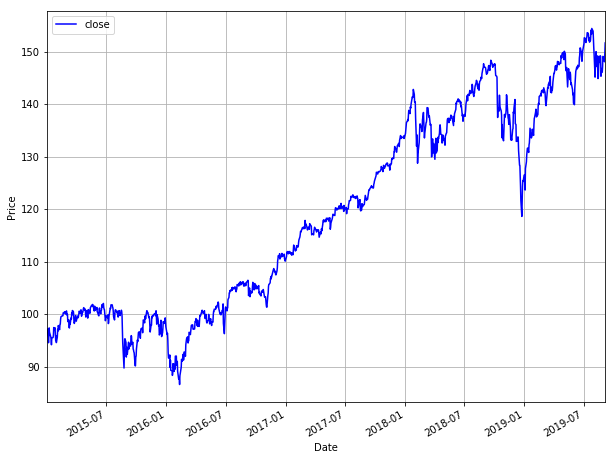

In [4]:
rcParams['figure.figsize'] = 10, 8

ax = df.plot(x='date', y='close', style='b-', grid=True)
ax.set_xlabel('Date')
ax.set_ylabel('Price')

In [5]:
#cross validation size
num_cv = int(cv_size*len(df))
#testing set size
num_test = int(test_size*len(df))
#training set size
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

#split the data set in train, cross validation and test
train = df[:num_train][['date', 'close']]
cv = df[num_train:num_train+num_cv][['date', 'close']]
train_cv = df[:num_train+num_cv][['date', 'close']]
test = df[num_train+num_cv:][['date', 'close']]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 707
num_cv = 235
num_test = 235
train.shape = (707, 2)
cv.shape = (235, 2)
train_cv.shape = (942, 2)
test.shape = (235, 2)


In [6]:
#scale the data into x_train and y_train
scaler = StandardScaler()
train_scaled = scaler.fit_transform(np.array(train['close']).reshape(-1,1))
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))

x_train_scaled, y_train_scaled = get_x_y(train_scaled, N, N)
print("x_train_scaled.shape = " + str(x_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape)) 

scaler.mean_ = [105.2850495]
scaler.var_ = [95.64876163]
x_train_scaled.shape = (698, 9, 1)
y_train_scaled.shape = (698, 1)


In [7]:
#scale the cv data
x_cv_scaled, y_cv, mu_cv, std_cv = get_x_scaled_y(np.array(train_cv['close']).reshape(-1,1), N, num_train)
print("x_cv_scaled.shape = " + str(x_cv_scaled.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("len(mu_cv_list) = " + str(len(mu_cv)))
print("len(std_cv_list) = " + str(len(std_cv)))


x_cv_scaled.shape = (235, 9, 1)
y_cv.shape = (235, 1)
len(mu_cv_list) = 235
len(std_cv_list) = 235


In [8]:
#scale train_cv for the final model
scaler_final = StandardScaler()
train_cv_scaled_final = scaler_final.fit_transform(np.array(train_cv['close']).reshape(-1,1))
print("scaler_final.mean_ = " + str(scaler_final.mean_))
print("scaler_final.var_ = " + str(scaler_final.var_))

# Scale the test dataset
x_test_scaled, y_test, mu_test_list, std_test_list = get_x_scaled_y(np.array(df['close']).reshape(-1,1), N, num_train+num_cv)
print("x_test_scaled.shape = " + str(x_test_scaled.shape))
print("y_test.shape = " + str(y_test.shape))
print("len(mu_test_list) = " + str(len(mu_test_list)))
print("len(std_test_list) = " + str(len(std_test_list)))

scaler_final.mean_ = [113.2468259]
scaler_final.var_ = [270.21547135]
x_test_scaled.shape = (235, 9, 1)
y_test.shape = (235, 1)
len(mu_test_list) = 235
len(std_test_list) = 235


In [9]:
#LSTM TIME
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train_scaled.shape[1],1)))
model.add(Dropout(1))
model.add(LSTM(units=50))
model.add(Dropout(1))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train_scaled, y_train_scaled, epochs=3, batch_size=1, verbose=2)


W0907 14:35:17.321210 4446397888 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0907 14:35:17.341579 4446397888 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0907 14:35:17.346026 4446397888 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0907 14:35:17.754313 4446397888 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0907 14:35:17.951972 4446397888 deprecation.py:323] From /usr/local/lib/pyt

Epoch 1/3
 - 9s - loss: 0.0478
Epoch 2/3
 - 7s - loss: 0.0256
Epoch 3/3
 - 7s - loss: 0.0163


In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 9, 50)             10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [11]:
estimated_scled = model.predict(x_cv_scaled)
est = (estimated_scled * np.array(std_cv).reshape(-1,1)) + np.array(mu_cv).reshape(-1,1)
print("est.shape = " + str(est.shape))

#Calculate the Mean Squared Error
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, est))
print('RMSE = %0.3f' % rmse_bef_tuning)

#Calculate Mean Absolute Percentage Error
mape_pct_bef_tuning = get_mape(y_cv, est)
print('MAPE = %0.3f%%' % mape_pct_bef_tuning)

est.shape = (235, 1)
RMSE = 1.413
MAPE = 0.756%


Text(0, 0.5, 'USD')

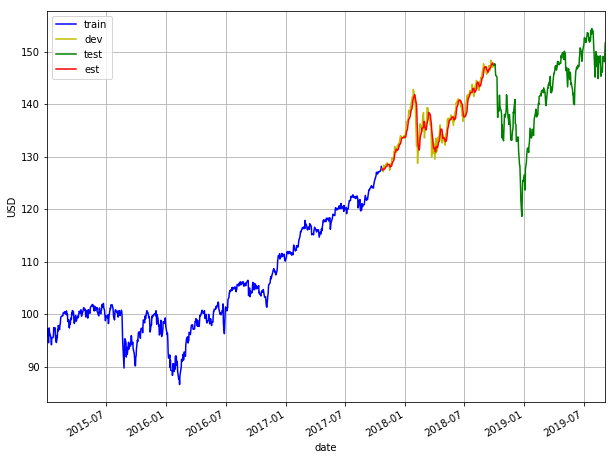

In [12]:
rcParams['figure.figsize'] = 10, 8

estimated_df = pd.DataFrame({'est':est.reshape(-1),
                            'y_cv':y_cv.reshape(-1),
                            'date':cv['date']})
ax = train.plot(x='date', y='close', style='b-', grid=True)
ax = cv.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='g-', grid=True, ax=ax)
ax = estimated_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'est'])
ax.set_xlabel('date')
ax.set_ylabel('USD')

In [13]:
param_label = 'N'
param_list = range(3, 60)

error_rate = {param_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
    #Split into x and y but we already did that
    x_train_scaled, y_train_scaled = get_x_y(train_scaled, param, param)
    #Split cv into x and y
    x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_x_scaled_y(np.array(train_cv['close']).reshape(-1, 1), 
                                                                param, 
                                                                num_train)
    print(x_train_scaled.shape)
    print(y_train_scaled.shape)

    #Train, predict and evaluate the model
    rmse, mape, _ = train_pred_eval_model(x_train_scaled,
                                          y_train_scaled,
                                          x_cv_scaled,
                                          y_cv,
                                          mu_cv_list,
                                          std_cv_list,
                                          lstm_units=50,
                                          dropout_prob=dropout_prob,
                                          optimizer='adam',
                                          epochs=1,
                                          batch_size=1)
    
    #Collect all the results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate

(704, 3, 1)
(704, 1)
(703, 4, 1)
(703, 1)
(702, 5, 1)
(702, 1)
(701, 6, 1)
(701, 1)
(700, 7, 1)
(700, 1)
(699, 8, 1)
(699, 1)
(698, 9, 1)
(698, 1)
(697, 10, 1)
(697, 1)
(696, 11, 1)
(696, 1)
(695, 12, 1)
(695, 1)
(694, 13, 1)
(694, 1)
(693, 14, 1)
(693, 1)
(692, 15, 1)
(692, 1)
(691, 16, 1)
(691, 1)
(690, 17, 1)
(690, 1)
(689, 18, 1)
(689, 1)
(688, 19, 1)
(688, 1)
(687, 20, 1)
(687, 1)
(686, 21, 1)
(686, 1)
(685, 22, 1)
(685, 1)
(684, 23, 1)
(684, 1)
(683, 24, 1)
(683, 1)
(682, 25, 1)
(682, 1)
(681, 26, 1)
(681, 1)
(680, 27, 1)
(680, 1)
(679, 28, 1)
(679, 1)
(678, 29, 1)
(678, 1)
(677, 30, 1)
(677, 1)
(676, 31, 1)
(676, 1)
(675, 32, 1)
(675, 1)
(674, 33, 1)
(674, 1)
(673, 34, 1)
(673, 1)
(672, 35, 1)
(672, 1)
(671, 36, 1)
(671, 1)
(670, 37, 1)
(670, 1)
(669, 38, 1)
(669, 1)
(668, 39, 1)
(668, 1)
(667, 40, 1)
(667, 1)
(666, 41, 1)
(666, 1)
(665, 42, 1)
(665, 1)
(664, 43, 1)
(664, 1)
(663, 44, 1)
(663, 1)
(662, 45, 1)
(662, 1)
(661, 46, 1)
(661, 1)
(660, 47, 1)
(660, 1)
(659, 48, 1)
(659

,N,rmse,mape_pct
0,3,1.427404,0.753805
1,4,1.520476,0.815142
2,5,1.660183,0.880763
3,6,1.722286,0.906011
4,7,1.848618,0.969544
5,8,1.816870,0.958636
6,9,1.850606,0.985986
7,10,1.886784,1.003618
8,11,1.917399,1.031503
9,12,1.819607,0.970859


Text(0, 0.5, 'RMSE / MAPE (%)')

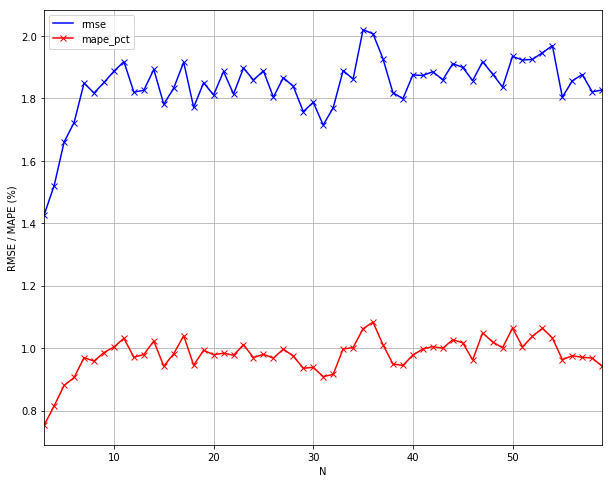

In [14]:
rcParams['figure.figsize'] = 10, 8

ax = error_rate.plot(x='N', y='rmse', style='bx-', grid=True)
ax = error_rate.plot(x='N', y='mape_pct', style='rx-', grid=True, ax=ax)
ax.set_xlabel('N')
ax.set_ylabel('RMSE / MAPE (%)')

In [15]:
# Get optimum value for param
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
N_opt = temp['N'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(N_opt))

min RMSE = 1.427
min MAPE = 0.754%
optimum N = 3


In [16]:
epoch_param_label = 'epochs'
epoch_param_list = [1, 10, 20, 30, 40, 50]

batch_param_label = 'batch_size'
batch_param_list = [8, 16, 32, 64, 128]

x_train_scaled, y_train_scaled = get_x_y(train_scaled, N_opt, N_opt)

x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_x_scaled_y(np.array(train_cv['close']).reshape(-1, 1), 
                                                                N_opt, 
                                                                num_train)

be_error_rate = {epoch_param_label: [], batch_param_label: [],'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(epoch_param_list):
    
    for param2 in tqdm_notebook(batch_param_list):
        
        rmse, mape, _ = train_pred_eval_model(x_train_scaled,
                                          y_train_scaled,
                                          x_cv_scaled,
                                          y_cv,
                                          mu_cv_list,
                                          std_cv_list,
                                          lstm_units=50,
                                          dropout_prob=dropout_prob,
                                          optimizer='adam',
                                          epochs=param,
                                          batch_size=param2)
        be_error_rate[epoch_param_label].append(param)
        be_error_rate[batch_param_label].append(param2)
        be_error_rate['rmse'].append(rmse)
        be_error_rate['mape_pct'].append(mape)

be_error_rate = pd.DataFrame(be_error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
be_error_rate



Minutes taken = 14.390383219718933


,epochs,batch_size,rmse,mape_pct
0,1,8,1.427749,0.751523
1,1,16,1.424976,0.753602
2,1,32,1.301341,0.684032
3,1,64,1.277821,0.671278
4,1,128,1.274961,0.670623
5,10,8,1.361915,0.716009
6,10,16,1.405422,0.741531
7,10,32,1.423919,0.751037
8,10,64,1.424257,0.751726
9,10,128,1.436213,0.765578


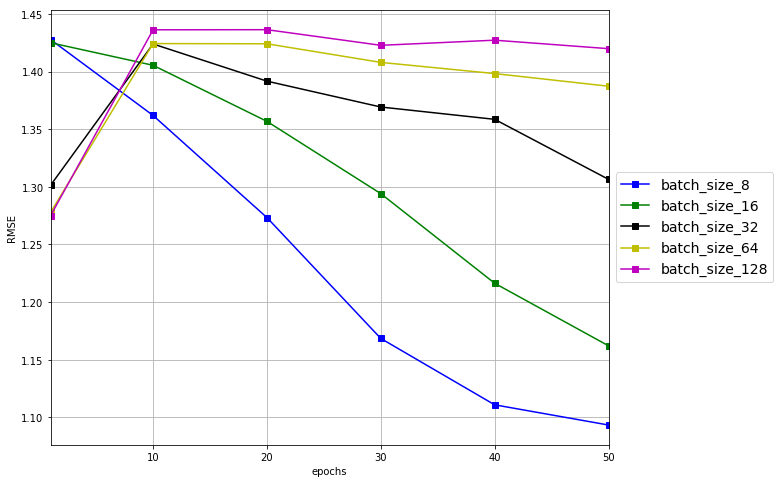

In [17]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = be_error_rate[be_error_rate[batch_param_label]==batch_param_list[0]]
ax = temp.plot(x=epoch_param_label, y='rmse', style='bs-', grid=True)
legend_list = [batch_param_label + '_' + str(batch_param_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(batch_param_list)):
    temp = be_error_rate[be_error_rate[batch_param_label]==batch_param_list[i]]
    ax = temp.plot(x=epoch_param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(batch_param_label + '_' + str(batch_param_list[i]))

ax.set_xlabel(epoch_param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [18]:
# Get optimum value for Epochs and Batch size
temp = be_error_rate[be_error_rate['rmse'] == be_error_rate['rmse'].min()]
epochs_opt = temp[epoch_param_label].values[0]
batch_size_opt = temp[batch_param_label].values[0]
print("min RMSE = %0.3f" % be_error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % be_error_rate['mape_pct'].min())
print("optimum " + epoch_param_label + " = " + str(epochs_opt))
print("optimum " + batch_param_label + " = " + str(batch_size_opt))

min RMSE = 1.093
min MAPE = 0.562%
optimum epochs = 50
optimum batch_size = 8


In [19]:
#Trying different LSTM units and Dropout probabilities
param_label = 'lstm_units'
param_list = [10, 50, 64, 128]

param2_label = 'dropout_prob'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [], param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
    
    for param2 in tqdm_notebook(param2_list):
        
        rmse, mape, _ = train_pred_eval_model(x_train_scaled,
                                          y_train_scaled,
                                          x_cv_scaled,
                                          y_cv,
                                          mu_cv_list,
                                          std_cv_list,
                                          lstm_units=param,
                                          dropout_prob=param2,
                                          optimizer=optimizer,
                                          epochs=epochs_opt,
                                          batch_size=batch_size_opt)
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)

error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate

W0907 15:20:52.385826 4446397888 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0907 15:21:49.034563 4446397888 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0907 15:21:49.211623 4446397888 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0907 15:22:49.584311 4446397888 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0907 15:22:49.757997 4446397888 nn_ops.py:4224] Large dropout 



Minutes taken = 26.709919969240826


,lstm_units,dropout_prob,rmse,mape_pct
0,10,0.5,1.378486,0.722685
1,10,0.6,1.404102,0.734510
2,10,0.7,1.389650,0.728625
3,10,0.8,1.403176,0.733505
4,10,0.9,1.339018,0.699961
5,10,1.0,1.224767,0.636202
6,50,0.5,1.271558,0.663027
7,50,0.6,1.298617,0.678252
8,50,0.7,1.349076,0.705354
9,50,0.8,1.401476,0.734988


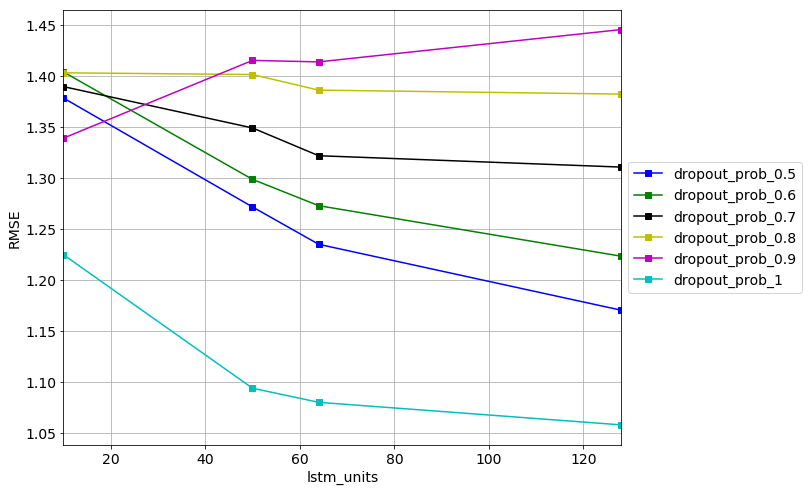

In [20]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [21]:
# Get optimum value for LSTM and Dropout
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
lstm_units_opt = temp[param_label].values[0]
dropout_prob_opt = temp[param2_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(lstm_units_opt))
print("optimum " + param2_label + " = " + str(dropout_prob_opt))

min RMSE = 1.058
min MAPE = 0.548%
optimum lstm_units = 128
optimum dropout_prob = 1.0


In [22]:
#Trying different optimizers
param_label = 'optimizer'
param_list = ['adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta' , 'adamax', 'nadam']

error_rate = {param_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
    
    rmse, mape, _ = train_pred_eval_model(x_train_scaled,
                                          y_train_scaled,
                                          x_cv_scaled,
                                          y_cv,
                                          mu_cv_list,
                                          std_cv_list,
                                          lstm_units=lstm_units_opt,
                                          dropout_prob=dropout_prob,
                                          optimizer=param,
                                          epochs=epochs_opt,
                                          batch_size=batch_size_opt)
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape_pct'].append(mape)

error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate


Minutes taken = 9.250364236036937


,optimizer,rmse,mape_pct
0,adam,1.059749,0.554340
1,sgd,1.340676,0.703347
2,rmsprop,1.062647,0.551436
3,adagrad,1.192426,0.616706
4,adadelta,1.089538,0.554420
5,adamax,1.064494,0.548106
6,nadam,1.058346,0.550573


Text(0, 0.5, 'RMSE / MAPE (%)')

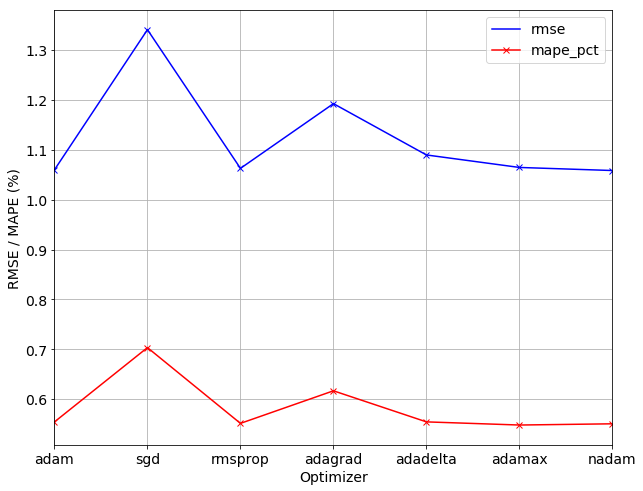

In [23]:
rcParams['figure.figsize'] = 10, 8

ax = error_rate.plot(x='optimizer', y='rmse', style='bx-', grid=True)
ax = error_rate.plot(x='optimizer', y='mape_pct', style='rx-', grid=True, ax=ax)
ax.set_xticklabels(param_list)
ax.set_xlabel('Optimizer')
ax.set_ylabel('RMSE / MAPE (%)')


In [24]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
optimizer_opt = temp[param_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(optimizer_opt))

min RMSE = 1.058
min MAPE = 0.548%
optimum optimizer = nadam


In [25]:
d = {'param': ['N', 'lstm_units', 'dropout_prob', 'optimizer', 'epochs', 'batch_size', 'rmse', 'mape_pct'],
     'original': [N, lstm_units, dropout_prob, optimizer, epochs, batch_size, rmse_bef_tuning, mape_pct_bef_tuning],
     'after_tuning': [N_opt, lstm_units_opt, dropout_prob_opt, optimizer_opt, epochs_opt, batch_size_opt, error_rate['rmse'].min(), error_rate['mape_pct'].min()]}
tuned_params = pd.DataFrame(d)
tuned_params

,param,original,after_tuning
0,N,9,3
1,lstm_units,50,128
2,dropout_prob,1,1
3,optimizer,adam,nadam
4,epochs,1,50
5,batch_size,1,8
6,rmse,1.41318,1.05835
7,mape_pct,0.755569,0.548106


In [76]:
# Split train_cv into x and y
x_train_cv_scaled, y_train_cv_scaled = get_x_y(train_cv_scaled_final, N_opt, N_opt)

# Split test into x and y
x_test_scaled, y_test, mu_test_list, std_test_list = get_x_scaled_y(np.array(df['close']).reshape(-1,1), N_opt, num_train+num_cv)

# Train, predict and eval model
rmse, mape, est, model = train_pred_eval_model(x_train_cv_scaled, 
                                        y_train_cv_scaled, 
                                        x_test_scaled, 
                                        y_test, 
                                        mu_test_list, 
                                        std_test_list, 
                                        lstm_units=lstm_units_opt, 
                                        dropout_prob=dropout_prob_opt, 
                                        optimizer=optimizer_opt, 
                                        epochs=epochs_opt, 
                                        batch_size=batch_size_opt)

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

RMSE on test set = 1.543
MAPE on test set = 0.806%


Text(0, 0.5, 'USD')

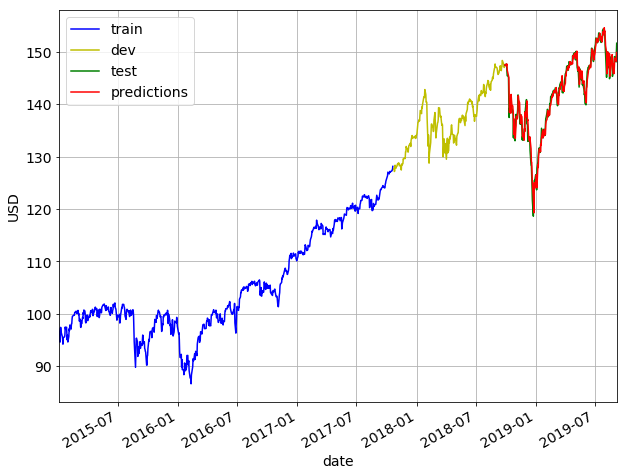

In [77]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est.reshape(-1), 
                       'date': df[num_train+num_cv:]['date']})

ax = train.plot(x='date', y='close', style='b-', grid=True)
ax = cv.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to test set')

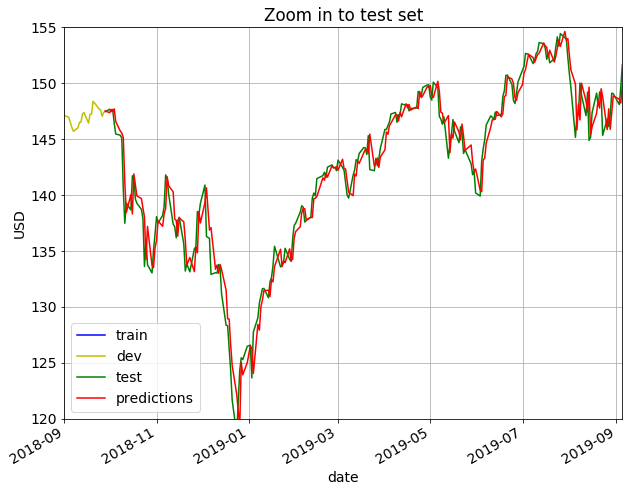

In [78]:
# Plot adjusted close over time, for test set only
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y='close', style='b-', grid=True)
ax = cv.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2018, 9, 1), date(2019, 9, 5)])
ax.set_ylim([120, 155])
ax.set_title("Zoom in to test set")

In [75]:
recent_data = df['close'].tail(120)
num_recent = len(recent_data)

x_future_scaled, y_scaled, future_mu, future_std = get_x_scaled_y(np.array(recent_data).reshape(-1,1), 
                                                                  N_opt, 
                                                                  num_recent)
# future_scaled = model.predict(x_future_scaled)
# future = (future_scaled * np.array(mu_test_list).reshape(-1,1)) + np.array(std_test_list).reshape(-1,1)

# future_df = pd.DataFrame({'est': future.reshape(-1), 
#                        'date': df[num_train+num_cv:]['date']})

x_future_scaled

array([], dtype=float64)